# Load Shedding, Shifting and Elastic Demand

This example is a simple illustration that aims to explain the use of load shedding, load shifting and elastic demand in PyPSA. The example is designed to simulate a single day of electrical consumption in a small network with solar generation, which could represent a single house or a small group of houses.

In [7]:
import pypsa
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

## Build example network

First, let's start building a minimal example network for which we demonstrate the demand modelling cases.
The example network is represented as single bus: 
- with one PV generator
- and one baseload electricity demand profile
- between 04:00 - 20:00

In [8]:
network = pypsa.Network()

# Add a bus
network.add("Bus", "My bus")

# Add fuel types
network.add("Carrier", "solar")
network.add("Carrier", "load")

# Add snapshots to define considered time span
network.set_snapshots(pd.date_range("2023-01-01 04:00", "2023-01-01 20:00", freq="H"))

# Add solar generation
pv_pu = [
    0.0,
    0.0,
    0.0,
    0.2,
    0.4,
    0.65,
    0.85,
    0.9,
    0.85,
    0.65,
    0.4,
    0.3,
    0.2,
    0.1,
    0.0,
    0.0,
    0.0,
]

# Add solar generation
network.add(
    "Generator",
    "solar",
    bus="My bus",
    p_nom=0.4,
    carrier="solar",
    p_max_pu=pv_pu,
    marginal_cost=0 + 0.01 * np.random.random(),
)

# Add baseload
load = pd.Series(0.2, index=range(17))  # constant baseload
network.add("Load", "baseload", bus="My bus", p_set=load.values)

## Load shedding

"Load shedding" in power networks often happens under extreme conditions, e.g. to prevent network faults. In models, we consider load shedding as extremely expensive and unconstrained generators that can practically decreases the demand to zero. Tip: Load shedding generators are often used to track-down infeasibilities making every model solve.

In [9]:
# Add load shedding as generator
network.add(
    "Generator",
    "load shedding",
    bus="My bus",
    p_nom=50,
    carrier="load",
    p_max_pu=1.0,
    marginal_cost=1e2,
    p_nom_extendable=True,
)

## Load shifting

"Load shifting" is often used to provide network benefits arising from demand side flexibility. One example application are smart thermostats that can shift the timing of energy use by automatically shifting the heating or cooling demand from one to another period e.g. from peak to off-peak period. We model load shifting as storage unit, which are often described as energy time-shifters.

In [10]:
# add battery as carrier
network.add("Carrier", "battery")

# add smart thermostat as storage unit
network.add(
    "StorageUnit",
    "smart thermostat",
    bus="My bus",
    p_nom=0,
    carrier="battery",
    marginal_cost=4 * np.random.random(),
    p_nom_extendable=True,
    p_max_pu=1,
    p_min_pu=-1,
    efficiency_store=0.9,
    efficiency_dispatch=0.95,
    standing_loss=0.01,
    cyclic_state_of_charge=True,
    max_hours=6,
)

### Let's plot load shifting and shedding 

In [11]:
network.lopf()

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.6s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+02


('ok', 'optimal')

In [18]:
network.generators_t.p

Generator,solar,load shedding
snapshot,,
2023-01-01 04:00:00,0.00,0.200000
2023-01-01 05:00:00,0.00,0.200000
2023-01-01 06:00:00,0.00,0.200000
2023-01-01 07:00:00,0.08,0.120000
2023-01-01 08:00:00,0.16,0.040000
2023-01-01 09:00:00,0.26,0.000000
2023-01-01 10:00:00,0.34,0.000000
2023-01-01 11:00:00,0.36,0.000000
2023-01-01 12:00:00,0.34,0.000000


Text(0, 0.5, 'Power (MW)')

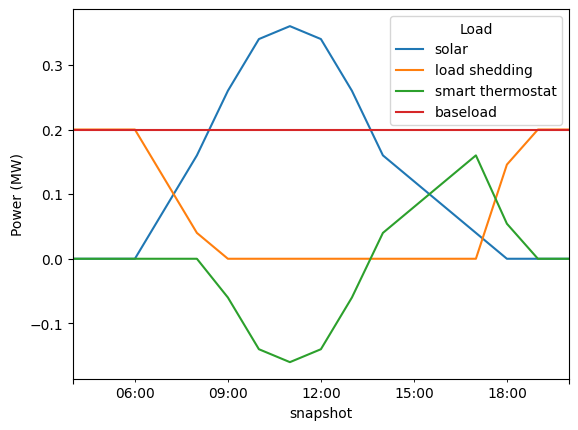

In [13]:
fig, ax = plt.subplots()

network.generators_t.p.plot(ax=ax)
network.storage_units_t.p.plot(ax=ax)
network.loads_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")

We can observe from the least cost solution the following:
- The smart thermostat is increasing the demand during the peak solar generation, to save energy when there is a lack of supply
- In the first and last hours of the day, load shedding is applied since there is not enough storage or generation available

## Elastic Demand

Demand is slightly "elastic", meaning consumers would use less energy if its too expensive, or would use more energy if its low costs. Think about yourself. Would you consume less energy if it cost 5x more than today? The elasticity of demand is usually nonlinear and highly depended on individuals. If you are interested to read more into this, [Labandeira et al. (2017)](https://doi.org/10.1016/j.enpol.2017.01.002) surveys 428 papers that use various econometric techniques to evaluate energy demand elasticity to price.

We model eleastic demand by:
  - using a linear elasticity curve (price & demand relation)
  - iteration model runs with updated demands
  
Note. Demand is model input & price is the model output. See [here](https://github.com/PyPSA/PyPSA/issues/574) a nice illustration. 

In [19]:
# assuming a linear demand response to price
def elasticity(system_cost_per_MWh):
    # y = mx + t
    # x = y - t / m
    return (system_cost_per_MWh - 120) / -300

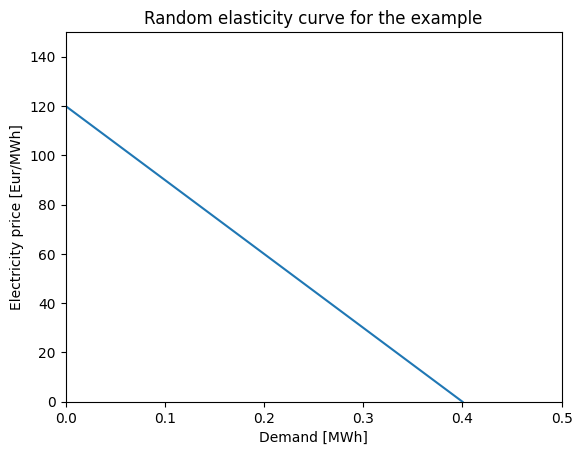

In [20]:
# Define a range of input values
x = np.arange(0, 300, 10)

# Calculate output values using the elasticity function
y = [elasticity(i) for i in x]

# Create the plot
plt.plot(y, x)
plt.xlabel("Demand [MWh]")
plt.ylabel("Electricity price [Eur/MWh]")
plt.title("Random elasticity curve for the example")
plt.xlim([0, 0.5])
plt.ylim([0, 150])
plt.show()

Using the same network as in the previous sections, we perform the iteration:
- add demand to network
- optimize network to get the system price
- update the demand by adding the system price to the elasticity curve

In [43]:
base_load = 0.2
all_networks = []

old_cost = 1e100
MAX_ITERATIONS = 10
THRESHOLD = 0.05  # minimum 5% change per iteration
for i in range(MAX_ITERATIONS):
    network = network.copy()
    load = pd.Series(
        base_load, index=range(17)
    )  # variable baseload based on base_load_values
    network.remove("Load", "baseload")
    network.add("Load", "baseload", bus="My bus", p_set=load.values)
    network.lopf()

    # Estimated price of the network in euros per MWh
    system_cost_per_MWh = (
        network.objective + network.objective_constant
    ) / network.loads_t.p.sum().sum()

    all_networks.append(network)
    if abs(old_cost - system_cost_per_MWh) / system_cost_per_MWh < THRESHOLD:
        break
    old_cost = system_cost_per_MWh
    # assuming a linear demand response to price
    new_load = elasticity(system_cost_per_MWh)
    base_load = new_load

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.38s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.32e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.41s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.45e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.36s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.68e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.37s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.15e+02
INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.37s
INFO:pypsa.linopf:Solve linear problem using Glpk s

In [44]:
abs(old_cost - system_cost_per_MWh) / system_cost_per_MWh

0.04785850340040847

In [42]:
system_cost_per_MWh

38.72139258823529

### Let's plot the elastic demand

In [33]:
### Demand and price values from the created networks
average_loads = []
prices = []
for n in all_networks:
    average_loads.append(n.loads_t.p.mean().sum())
    prices.append((n.objective + n.objective_constant) / n.loads_t.p.sum().sum())

In [34]:
prices

[38.72139258823529,
 53.185475844542566,
 44.28097203833327,
 50.08850663833057,
 46.459285283794166,
 48.79451788386018]

0.04785850340040847

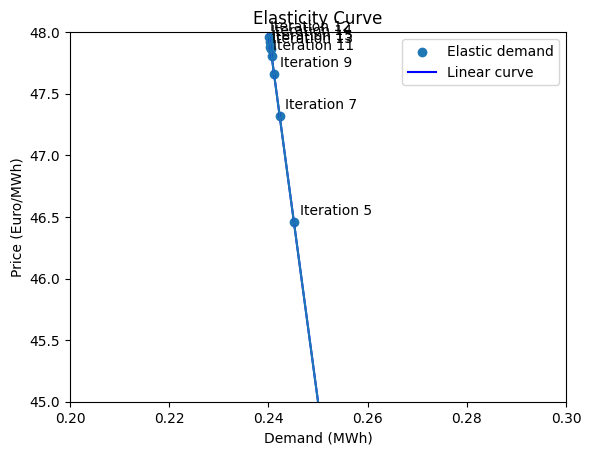

In [29]:
first_demand_iteration = average_loads[0]
updated_average_loads = average_loads[
    1:
]  # demand value in first iteration didn't have a price
updated_prices = prices[:-1]  # last price value wasn't used

# Scatter plot of the points
plt.scatter(updated_average_loads, updated_prices, label="Elastic demand")

# Add numbers to each point
for i, (x, y) in enumerate(zip(updated_average_loads, updated_prices)):
    plt.annotate(
        "Iteration " + str(i + 1),
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
    )

# Fit a linear curve to the data
slope, intercept = np.polyfit(updated_average_loads, updated_prices, 1)

# Linear curve
x = np.linspace(min(updated_average_loads), max(updated_average_loads), 100)
y = slope * x + intercept
plt.plot(x, y, label=f"Linear curve", color="blue")

plt.xlabel("Demand (MWh)")
plt.ylabel("Price (Euro/MWh)")
plt.title("Elasticity Curve")
plt.legend(loc="upper right")
plt.xlim([0.2, 0.3])
plt.ylim([35, 60])
plt.plot(x, y)
plt.show()

In [31]:
y

array([53.18547584, 53.03937399, 52.89327214, 52.74717029, 52.60106844,
       52.45496659, 52.30886474, 52.16276289, 52.01666104, 51.87055918,
       51.72445733, 51.57835548, 51.43225363, 51.28615178, 51.14004993,
       50.99394808, 50.84784623, 50.70174438, 50.55564253, 50.40954067,
       50.26343882, 50.11733697, 49.97123512, 49.82513327, 49.67903142,
       49.53292957, 49.38682772, 49.24072587, 49.09462401, 48.94852216,
       48.80242031, 48.65631846, 48.51021661, 48.36411476, 48.21801291,
       48.07191106, 47.92580921, 47.77970735, 47.6336055 , 47.48750365,
       47.3414018 , 47.19529995, 47.0491981 , 46.90309625, 46.7569944 ,
       46.61089255, 46.4647907 , 46.31868884, 46.17258699, 46.02648514,
       45.88038329, 45.73428144, 45.58817959, 45.44207774, 45.29597589,
       45.14987404, 45.00377218, 44.85767033, 44.71156848, 44.56546663,
       44.41936478, 44.27326293, 44.12716108, 43.98105923, 43.83495738,
       43.68885552, 43.54275367, 43.39665182, 43.25054997, 43.10

We can observe from the elastic demand the following:
- Our initial average demand estimate of 0.2 MWh lead to a price resulting in more demand -> **iteration 1**.
- Using the new demand derieved from the elasticity curve and **iteration 1**, increased the average system price -> **iteration 2**
- ...
Luckily, after several iterations we observe that the results are **converging.**

**Note.** Here we solve the elastic demand as linear programming (LP) problem and several iterations. It is also possible to solve the problem with **one single** optimization run. However, this requires to reformulate the problem as quadratic programming (QP) problem, see [here](https://github.com/PyPSA/PyPSA/issues/574#issuecomment-1451865672). PyPSA can also do that, however, we need to add the QP solving capability to Linopy. This is already tracked as [feature request](https://github.com/PyPSA/linopy/issues/18) and can be done in several months. 